In [1]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from s4 import S4Block

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
# Load the dataset
name_data_file = 'ETTh1.csv'  # you can exchange the used file here
df = pd.read_csv(name_data_file)

In [3]:
# Look into data set size and number of features
df.shape

(17320, 4)

In [4]:
# Let's focus on just one feature for simplicity: 'OT' (oil temperature)
data = df['OT'].values
data[:10]

array([30.53100014, 27.78700066, 27.78700066, 25.04400063, 21.94799995,
       21.17399979, 22.79199982, 23.1439991 , 21.66699982, 17.44599915])

In [5]:
# Normalize the data
data_mean = data.mean()
data_std = data.std()
normalized_data = (data - data_mean) / data_std

In [6]:
normalized_data[:10]

array([2.00156797, 1.68184735, 1.68184735, 1.36224319, 1.00150869,
       0.91132507, 1.09984842, 1.14086207, 0.9687676 , 0.47695229])

In [7]:
# Define a function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

In [8]:
# Create sequences with a sequence length of 50
SEQ_LENGTH = 50
X, y = create_sequences(normalized_data, SEQ_LENGTH)

# Split the data into train and test sets
split_ratio = 0.8
split = int(split_ratio * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
X[0][:5], X[1][:5]

(array([2.00156797, 1.68184735, 1.68184735, 1.36224319, 1.00150869]),
 array([1.68184735, 1.68184735, 1.36224319, 1.00150869, 0.91132507]))

In [10]:
normalized_data[-2], normalized_data[-1]

(np.float64(-1.0722480936144267), np.float64(-1.0148055625405703))

In [11]:
X[0][-1], normalized_data[50], y[0], X[1][-1], y[1]

(np.float64(1.4768951204829002),
 np.float64(1.280215666784265),
 np.float64(1.280215666784265),
 np.float64(1.280215666784265),
 np.float64(1.5260650950261445))

In [12]:
y[0], y[1]

(np.float64(1.280215666784265), np.float64(1.5260650950261445))

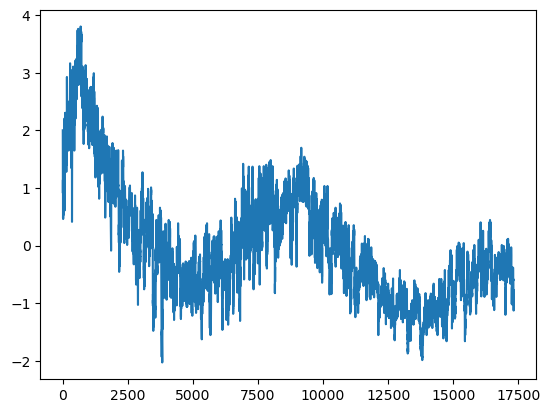

In [13]:
plt.plot(np.arange(len(normalized_data)), normalized_data)
plt.savefig(f'plt-{name_data_file.replace(".csv", "")}-full.png')
plt.show()

In [14]:

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Inspect the data shapes

In [15]:
sample_feats, sample_targs = next(iter(train_loader))

In [16]:
sample_feats.shape, sample_targs.shape

(torch.Size([64, 50]), torch.Size([64]))

# Recurrent Neural Network

In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [18]:
# Instantiate the model, define loss function and optimizer
model_rnn = RNNModel().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

### Inspection of the RNN

In [19]:
model_rnn.rnn._flat_weights_names

['weight_ih_l0',
 'weight_hh_l0',
 'bias_ih_l0',
 'bias_hh_l0',
 'weight_ih_l1',
 'weight_hh_l1',
 'bias_ih_l1',
 'bias_hh_l1']

In [20]:
model_rnn.rnn.weight_ih_l0.shape, model_rnn.rnn.weight_ih_l1.shape

(torch.Size([64, 1]), torch.Size([64, 64]))

In [21]:
model_rnn.rnn.weight_hh_l0.shape, model_rnn.rnn.weight_hh_l1.shape

(torch.Size([64, 64]), torch.Size([64, 64]))

In [22]:
example_h0 = torch.zeros(model_rnn.num_layers, sample_feats.size(0), model_rnn.hidden_size).to(sample_feats.device)
example_rnn = nn.RNN(1, model_rnn.hidden_size, model_rnn.num_layers, batch_first=True)
example_h0.shape

torch.Size([2, 64, 64])

In [23]:
example_rnn

RNN(1, 64, num_layers=2, batch_first=True)

In [24]:
#example_h1, example_z = example_rnn(sample_feats, example_h0)
#example_h1.shape, example_z.shape

### Conduct RNN Training

In [25]:
def train_model_rnn(model, train_loader, criterion, optimizer, num_epochs=20):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(-1))  # Add the extra dimension for input
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

In [26]:
%%time
# Perform training
train_model_rnn(model_rnn, train_loader, criterion_rnn, optimizer_rnn)

Epoch 1/20, Loss: 0.061785696430080056
Epoch 2/20, Loss: 0.015043495979625732
Epoch 3/20, Loss: 0.013826478339507486
Epoch 4/20, Loss: 0.013948044330054135
Epoch 5/20, Loss: 0.01394062992012887
Epoch 6/20, Loss: 0.01376065473218828
Epoch 7/20, Loss: 0.013675789693715397
Epoch 8/20, Loss: 0.01379640832224309
Epoch 9/20, Loss: 0.014007145944223911
Epoch 10/20, Loss: 0.01401800219900906
Epoch 11/20, Loss: 0.01391024570437838
Epoch 12/20, Loss: 0.013570403335271057
Epoch 13/20, Loss: 0.013850594997940655
Epoch 14/20, Loss: 0.013598976613677762
Epoch 15/20, Loss: 0.013417721555689004
Epoch 16/20, Loss: 0.013967921942282744
Epoch 17/20, Loss: 0.013558207278105396
Epoch 18/20, Loss: 0.013473028349431438
Epoch 19/20, Loss: 0.013636420353712445
Epoch 20/20, Loss: 0.013465246248179701
CPU times: user 8min 30s, sys: 11.1 s, total: 8min 42s
Wall time: 2min 13s


In [27]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch.unsqueeze(-1))
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())

    return np.array(predictions).squeeze(), np.array(actuals)

In [28]:
preds_rnn, actuals_rnn = evaluate_model(model_rnn, test_loader)

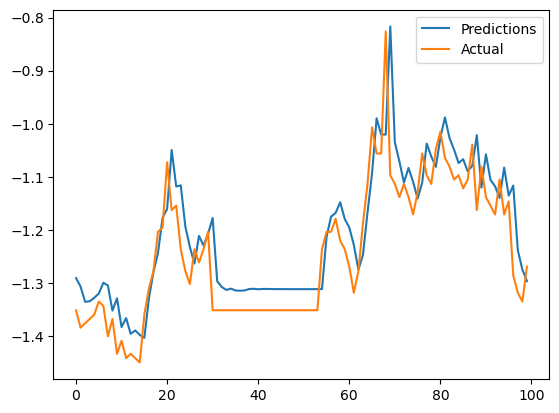

In [29]:
# Plot the predictions vs actual values
plt.plot(preds_rnn[:100], label='Predictions')
plt.plot(actuals_rnn[:100], label='Actual')
plt.legend()
plt.savefig(f'plt-model-rnn-predictions.png')
plt.show()

# Transformer

In [30]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)  # Final linear layer to map the Transformer output to a single value

        self.input_projection = nn.Linear(input_size, d_model)  # Input projection to match the model dimension

    def forward(self, src):
        # Project the input to d_model dimensions
        src = self.input_projection(src)
        
        # Add positional encodings
        src = self.pos_encoder(src)

        # Pass through the Transformer Encoder
        output = self.transformer_encoder(src)

        # We take the output at the last time step and map it to the final prediction
        output = self.fc(output[:, -1, :])  # Output at the last time step
        return output


class PositionalEncoding(nn.Module):
    """Inject some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [31]:
# Define the transformer model
model_transformer = TransformerTimeSeries().to('cuda' if torch.cuda.is_available() else 'cpu')

/home/julian/miniforge3/envs/sur-blog-transformers-s4/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Inspection of the Transformer components

How does the postitional encoding parameter *pe* come into place?

In [32]:
example_pe = PositionalEncoding(64, 0.1)
example_pe.pe.shape

torch.Size([5000, 1, 64])

First, a matrix of 5000 (the maximum sequence length considered by the positional encoding) times the dimensionality (=64) is initialized with zeros:

In [33]:
ex_pe = torch.zeros(5000, 64)
ex_pe.shape, ex_pe[0][:5]

(torch.Size([5000, 64]), tensor([0., 0., 0., 0., 0.]))

Then, a position index from 0 up to 4999 (=5000 max) is initialized and turned into a shape of a (5000,1) matrix, matching the positional encoding matrix *ex_pe*:

In [34]:
ex_position = torch.arange(0, 5000, dtype=torch.float).unsqueeze(1)
ex_position.shape, ex_position[:3], ex_position[-3:]

(torch.Size([5000, 1]),
 tensor([[0.],
         [1.],
         [2.]]),
 tensor([[4997.],
         [4998.],
         [4999.]]))

In [35]:
ex_div_term = torch.exp(torch.arange(0, 64, 2).float() * (-math.log(10000.0) / 64))
ex_div_term, ex_div_term.shape

(tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
         1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
         3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
         5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
         1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
         1.7783e-04, 1.3335e-04]),
 torch.Size([32]))

In [36]:
ex_position[:, 0::2].shape

torch.Size([5000, 1])

In [37]:
ex_pe[:, 0::2] = torch.sin(ex_position * ex_div_term)
ex_pe[:, 1::2] = torch.cos(ex_position * ex_div_term)
ex_pe.shape, ex_pe[0][:5], ex_pe[1][:5], ex_pe[2][:5]

(torch.Size([5000, 64]),
 tensor([0., 1., 0., 1., 0.]),
 tensor([0.8415, 0.5403, 0.6816, 0.7318, 0.5332]),
 tensor([ 0.9093, -0.4161,  0.9975,  0.0709,  0.9021]))

In [38]:
ex_pe = ex_pe.unsqueeze(0).transpose(0, 1)
ex_pe.shape

torch.Size([5000, 1, 64])

In [39]:
tmp_input_proj = nn.Linear(50, 64)
ex_x = tmp_input_proj(sample_feats)
ex_x.shape, tmp_input_proj.weight.shape

(torch.Size([64, 64]), torch.Size([64, 50]))

In [40]:
ex_positionencoded = ex_x + ex_pe[:ex_x.size(0), :]
ex_positionencoded.shape

torch.Size([64, 64, 64])

In [41]:
ex_x[0][:5]

tensor([ 0.5428, -0.6749,  0.0170,  0.1328,  0.0963], grad_fn=<SliceBackward0>)

In [42]:
ex_positionencoded[0][0][:5]

tensor([0.5428, 0.3251, 0.0170, 1.1328, 0.0963], grad_fn=<SliceBackward0>)

### Training a Transformer on the ET data

In [43]:
# Loss function and optimizer
criterion_transformer = nn.MSELoss()
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.001)

In [44]:
# Train the transformer model
def train_transformer_model(model, train_loader, criterion, optimizer, num_epochs=20):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(-1))  # Add extra dimension for input
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

In [45]:
%%time
# Train the model
train_transformer_model(model_transformer, train_loader, criterion_transformer, optimizer_transformer)

Epoch 1/20, Loss: 0.06493341810225199
Epoch 2/20, Loss: 0.028912443594351685
Epoch 3/20, Loss: 0.02518722930647157
Epoch 4/20, Loss: 0.023679303514115787
Epoch 5/20, Loss: 0.02233641548944568
Epoch 6/20, Loss: 0.022627158504393365
Epoch 7/20, Loss: 0.021561551537295734
Epoch 8/20, Loss: 0.021037491586024838
Epoch 9/20, Loss: 0.020879675207349162
Epoch 10/20, Loss: 0.01969923424379279
Epoch 11/20, Loss: 0.019536559336335847
Epoch 12/20, Loss: 0.01940245000662765
Epoch 13/20, Loss: 0.01972164256342997
Epoch 14/20, Loss: 0.01880586424118115
Epoch 15/20, Loss: 0.01852085062785557
Epoch 16/20, Loss: 0.019140684890940233
Epoch 17/20, Loss: 0.018154539734866745
Epoch 18/20, Loss: 0.018729614857066836
Epoch 19/20, Loss: 0.018018009751190053
Epoch 20/20, Loss: 0.01820205263276067
CPU times: user 27min 59s, sys: 49.6 s, total: 28min 48s
Wall time: 7min 31s


In [46]:
# Evaluate the transformer model
def evaluate_transformer_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch.unsqueeze(-1))
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())

    return np.array(predictions).squeeze(), np.array(actuals)

In [47]:
preds_transformer, actuals_transformer = evaluate_transformer_model(model_transformer, test_loader)

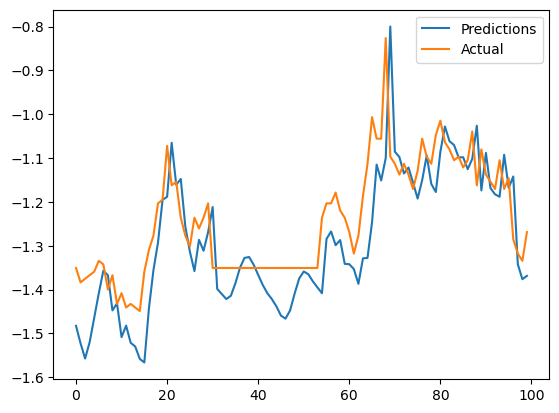

In [48]:
# Plot the predictions vs actual values
plt.plot(preds_transformer[:100], label='Predictions')
plt.plot(actuals_transformer[:100], label='Actual')
plt.legend()
plt.savefig(f'plt-model-transformer-predictions.png')
plt.show()

# S4 model

In [49]:
class S4Model(nn.Module):
    def __init__(self, input_size=1, d_model=64, num_layers=2):
        super(S4Model, self).__init__()
        
        self.d_model = d_model
        self.encoder = nn.Linear(input_size, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.s4 = S4Block(d_model)  # The S4 block from the library
        self.decoder = nn.Linear(d_model, 1)  # Final linear layer for regression output

    def forward(self, x):
        # Input x is shape (B, L, d_input)
        h = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        # Pre-Norm
        h = h.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        h = self.norm(h.transpose(-1, -2)).transpose(-1, -2)
        
        # Pass through S4
        h, _ = self.s4(h)
        h = h.transpose(-1, -2) # (B, L, d_model) -> (B, d_model, L)

        # Pooling: average pooling over the sequence length
        h = h.mean(dim=1)  # (B, d_model, L) -> (B, d_model)
        
        # Output at the last time step
        h = self.decoder(h)  # (B, d_model) -> (B, d_output)
        return h

In [50]:
# Define the S4 model
model_s4 = S4Model().to('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# Loss function and optimizer
criterion_s4 = nn.MSELoss()
optimizer_s4 = optim.Adam(model_s4.parameters(), lr=0.001)

In [52]:
# Train the S4 model
def train_s4_model(model, train_loader, criterion, optimizer, num_epochs=20):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(-1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

### Inspection of the Transformer components

In [53]:
model_s4.s4

S4Block(
  (layer): FFTConv(
    (activation): GELU(approximate='none')
    (kernel): SSMKernelDPLR()
    (drop): Identity()
    (drop_kernel): Identity()
  )
  (mult_activation): Identity()
  (drop): Identity()
  (output_linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): GLU(dim=-1)
  )
)

In [54]:
sample_feats.shape

torch.Size([64, 50])

In [55]:
# Input x is shape (B, L, d_input)
exs4_x = sample_feats.unsqueeze(-1)
exs4_x.shape

torch.Size([64, 50, 1])

In [56]:
exs4_encoder = nn.Linear(1, 64)
exs4_encoder

Linear(in_features=1, out_features=64, bias=True)

In [57]:
exs4_h = exs4_encoder(exs4_x) # (B, L, d_input) -> (B, L, d_model)
exs4_h.shape

torch.Size([64, 50, 64])

In [58]:
exs4_h = exs4_h.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
exs4_h.shape

torch.Size([64, 64, 50])

In [59]:
exs4_norm = nn.LayerNorm(64)
exs4_norm

LayerNorm((64,), eps=1e-05, elementwise_affine=True)

In [60]:
exs4_h = exs4_norm(exs4_h.transpose(-1, -2)).transpose(-1, -2)
exs4_h.shape

torch.Size([64, 64, 50])

In [61]:
exs4_layer = S4Block(64)
exs4_layer

S4Block(
  (layer): FFTConv(
    (activation): GELU(approximate='none')
    (kernel): SSMKernelDPLR()
    (drop): Identity()
    (drop_kernel): Identity()
  )
  (mult_activation): Identity()
  (drop): Identity()
  (output_linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): GLU(dim=-1)
  )
)

In [62]:
exs4_h, _ = exs4_layer(exs4_h)
exs4_h.shape

torch.Size([64, 64, 50])

In [63]:
exs4_h = exs4_h.transpose(-1, -2) # (B, L, d_model) -> (B, d_model, L)
exs4_h.shape

torch.Size([64, 50, 64])

In [64]:
exs4_h2 = exs4_h.mean(dim=1)  # (B, d_model, L) -> (B, d_model)
exs4_h2.shape

torch.Size([64, 64])

In [65]:
exs4_decoder = nn.Linear(64, 1)
exs4_decoder

Linear(in_features=64, out_features=1, bias=True)

In [66]:
exs4_h2 = exs4_decoder(exs4_h2)  # (B, d_model) -> (B, d_output)
exs4_h2.shape

torch.Size([64, 1])

### Training the S4 model on the ET data set

In [67]:
%%time
# Train the model
train_s4_model(model_s4, train_loader, criterion_s4, optimizer_s4)

Epoch 1/20, Loss: 0.1296182539038084
Epoch 2/20, Loss: 0.06279222956962055
Epoch 3/20, Loss: 0.04842608581573047
Epoch 4/20, Loss: 0.03764146645725877
Epoch 5/20, Loss: 0.031141218207604078
Epoch 6/20, Loss: 0.02716129328796847
Epoch 7/20, Loss: 0.023985140073044156
Epoch 8/20, Loss: 0.02159577899362409
Epoch 9/20, Loss: 0.01980742385516081
Epoch 10/20, Loss: 0.018719567710326776
Epoch 11/20, Loss: 0.017736517311142827
Epoch 12/20, Loss: 0.017398987142196683
Epoch 13/20, Loss: 0.016540537877180787
Epoch 14/20, Loss: 0.015334663257278778
Epoch 15/20, Loss: 0.014954308127656716
Epoch 16/20, Loss: 0.014651316149091279
Epoch 17/20, Loss: 0.014257309044262877
Epoch 18/20, Loss: 0.014200209323058112
Epoch 19/20, Loss: 0.013686387493551054
Epoch 20/20, Loss: 0.013690153654250834
CPU times: user 9min 11s, sys: 11.2 s, total: 9min 22s
Wall time: 2min 25s


In [68]:
# Evaluate the S4 model
def evaluate_s4_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch.unsqueeze(-1))
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())

    return np.array(predictions).squeeze(), np.array(actuals)

In [69]:
preds_s4, actuals_s4 = evaluate_s4_model(model_s4, test_loader)

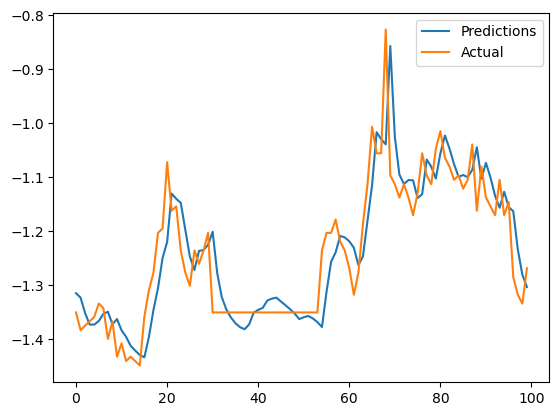

In [70]:
# Plot the predictions vs actual values
plt.plot(preds_s4[:100], label='Predictions')
plt.plot(actuals_s4[:100], label='Actual')
plt.legend()
plt.savefig(f'plt-model-s4-predictions.png')
plt.show()

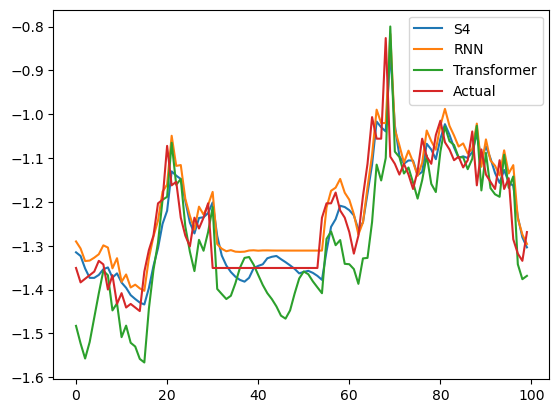

In [71]:
# Plot the predictions vs actual values
plt.plot(preds_s4[:100], label='S4')
plt.plot(preds_rnn[:100], label='RNN')
plt.plot(preds_transformer[:100], label='Transformer')
plt.plot(actuals_s4[:100], label='Actual')
plt.legend()
plt.savefig(f'plt-all-predictions.png')
plt.show()